### Импорт необходимых библиотек

In [79]:
import imageio    as II
import numpy      as np
import os         as os
import tensorflow as tf
import gc

from IPython.display             import Image
from tensorflow.keras.layers     import MaxPool2D, RepeatVector, Dropout,         Input,     Dense
from tensorflow.keras.layers     import Reshape,   Conv2D,       Conv2DTranspose, LeakyReLU, Flatten
from tensorflow.keras.layers     import Lambda,    concatenate,  UpSampling2D,    BatchNormalization
from tensorflow.keras.models     import Model
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets   import mnist
from tensorflow.keras.utils      import to_categorical
from tensorflow.keras.losses     import binary_crossentropy
from IPython.display             import clear_output as CO
from matplotlib                  import pyplot       as plt
from keras                       import backend      as KK
from tensorflow.keras            import backend      as TK


### Общие константы

In [80]:
latent_dim   = 8  # Размерность скрытого пространства
epochs       = 20000 # Количество эпох обучения
batch_size   = 64 # Размер батча при обучении
dropout_rate = 0.5
num_classes  = 10
gamma        = 1 # Коэффициент гамма
foldernum    = 0
alpha        = 0.2

internal_train_cycles = 3


### Загрузка и предобработка данных MNIST

In [81]:
# Загрузка и нормализация данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train     = x_train.astype('float32') / 255.
x_test      = x_test.astype('float32') / 255.
x_train     = np.expand_dims(x_train, axis=-1)
x_test      = np.expand_dims(x_test, axis=-1)
y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)

y_indeces = np.zeros((10, 10), dtype=int)
for i in range(10):
    indeces      = np.where(y_test == i)[0]
    y_indeces[i] = indeces[:10]


### Создание необходимых классов

In [82]:
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded, z_mean, z_log_var = inputs
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(x),
                                                tf.keras.backend.flatten(x_decoded))) * 28 * 28
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss) * -0.5
        vaeloss = reconstruction_loss + kl_loss
        self.add_loss(vaeloss)
        return x_decoded

class TripletLossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(TripletLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        anchor, positive, negative, output = inputs
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + alpha
        loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
        self.add_loss(loss)
        return output

class LocalDis (tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LocalDis, self).__init__(**kwargs)

    def call(self, inputs):
        discriminator.trainable = False
        #return discriminator([decoder([inputs[0], inputs[1]]), inputs[1]])
        return discriminator([vae([inputs[0], inputs[1]]), inputs[1]])


### Создание необходимых функций

In [83]:
def sampling(args):
    z_mean, z_log_var = args
    batch   = tf.shape(z_mean)[0]
    dim     = tf.shape(z_mean)[1]
    epsilon = TK.random_normal(shape=(batch, dim))
    sam_out = z_mean + tf.exp(tf.clip_by_value(z_log_var / 2, -2, 2)) * epsilon
    return sam_out

def sampling_shape(input_shape):
    shape = list(input_shape[0])
    samsh = tuple(shape)
    return samsh

def add_units_to_conv2d(conv2, units):
    dim1     = int(conv2.shape[1])
    dim2     = int(conv2.shape[2])
    dimc     = int(units.shape[1])
    repeat_n = dim1*dim2
    units_repeat = RepeatVector(repeat_n)(units)
    units_repeat = Reshape((dim1, dim2, dimc))(units_repeat)
    return concatenate([conv2, units_repeat])

def create_folder():
    global foldernum
    for i in range(6666):
        if os.path.exists(f'images/images_{i}'):
            if len(os.listdir(f'images/images_{i}')) == 0:
                print(f'Images_{i} folder is empty')
                foldernum = i
                break

        else:
            os.makedirs(f'images/images_{i}')
            print(f'Images_{i} folder created')
            foldernum = i
            break

# Рисование изображения 10 на 10
def plot_images_train(inputs1, inputs2, epoch):

    plt.figure(figsize=(10, 10))
    for i in range(10):
        ii = x_test[y_indeces[i]]
        jj = y_test_cat[y_indeces[i]]
        oo = vae.predict([ii, jj])
        for j in range(10):
            ax = plt.subplot(10, 10, 10 * i + j + 1)
            plt.imshow(oo[j].reshape(28, 28), cmap='gray')
            ax.axis('off')
    global foldernum
    print(foldernum)
    formatted_epoch = f'{epoch:05}'
    plt.suptitle(f'Epoch: {epoch}')
    plt.savefig(f'images/images_{foldernum}/epoch_{formatted_epoch}_reconstructions.png')
    plt.show()

# Рисование изображения 10 на 2
def plot_images(inputs, outputs, epoch, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Входные изображения
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(inputs[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

        # Восстановленные изображения
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(outputs[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

    plt.suptitle(f'Epoch: {epoch}')
    plt.show()

# Рисование графиков потерь
def loss_graph(d_losses, g_losses, vae_losses):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Losses')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(g_losses[0], g_losses[1], label='Triplet Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Losses')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(vae_losses, label='VAE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Losses')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Создание триплетов
def apn_idxes(idx, type):
            imgs         = []
            beton        = []
            positive_idx = []
            negative_idx = []
            if type == 'train':
                anchor_imgs  = x_train[idx]
                anchor_beton = y_train_cat[idx]
                size = batch_size
            if type == 'test':
                anchor_imgs  = x_test[idx]
                anchor_beton = y_test_cat[idx]
                size = 10
            for i in range(size):
                while True:
                    if type == 'train':
                        t   = np.random.randint(0, x_train.shape[0])
                        cat = str(y_train_cat[t])
                    if type == 'test':
                        t   = np.random.randint(0, x_test.shape[0])
                        cat = str(y_test_cat[t])
                    if (cat == str(anchor_beton[i])) & (i != t):
                        positive_idx.append(t)
                        break
            for i in range(size):
                while True:
                    if type == 'train':
                        t   = np.random.randint(0, x_train.shape[0])
                        cat = str(y_train_cat[t])
                    if type == 'test':
                        t   = np.random.randint(0, x_test.shape[0])
                        cat = str(y_test_cat[t])
                    if cat != str(anchor_beton[i]):
                        negative_idx.append(t)
                        break
            if type == 'train':
                positive_imgs  = x_train[positive_idx]
                negative_imgs  = x_train[negative_idx]
                positive_beton = y_train_cat[idx]
                negative_beton = y_train_cat[idx]
            if type == 'test':
                positive_imgs  = x_test[positive_idx]
                negative_imgs  = x_test[negative_idx]
                positive_beton = y_test_cat[idx]
                negative_beton = y_test_cat[idx]
            imgs.append(anchor_imgs)
            imgs.append(positive_imgs)
            imgs.append(negative_imgs)
            beton.append(anchor_beton)
            beton.append(positive_beton)
            beton.append(negative_beton)
            return imgs, beton

### Кодировщик

In [84]:
enc_input = Input(shape=(28, 28, 1))
enc_beton = Input(shape=(10,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(enc_input)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = concatenate([x, enc_beton])
x = Dense(latent_dim, activation='relu')(x)

z_mean    = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
enc_out   = Lambda(sampling, output_shape=sampling_shape)([z_mean, z_log_var])

encoder = Model([enc_input, enc_beton], [z_mean, z_log_var, enc_out], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_99 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 28, 28, 32)           320       ['input_99[0][0]']            
                                                                                                  
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 32)           0         ['conv2d_28[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 14, 14, 64)           18496     ['max_pooling2d_14[0][0]

### Декодировщик

In [85]:
dec_input = Input(shape=(latent_dim,))
dec_beton = Input(shape=(10,))

x = concatenate([dec_input, dec_beton])
x = Dense(7 * 7 * 128, activation='relu')(x)
x = Reshape((7, 7, 128))(x)
x = UpSampling2D(size=(4, 4))(x)
x = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
dec_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = Model([dec_input, dec_beton], dec_output, name='decoder')
decoder.summary()


Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_101 (InputLayer)      [(None, 8)]                  0         []                            
                                                                                                  
 input_102 (InputLayer)      [(None, 10)]                 0         []                            
                                                                                                  
 concatenate_22 (Concatenat  (None, 18)                   0         ['input_101[0][0]',           
 e)                                                                  'input_102[0][0]']           
                                                                                                  
 dense_45 (Dense)            (None, 6272)                 119168    ['concatenate_22[0][0]']

### Дискриминатор

In [86]:
dis_input = Input(shape=(28, 28, 1))
dis_beton = Input(shape=(10,))

x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(dis_input)
x = MaxPool2D((2, 2), padding='same')(x)
x = add_units_to_conv2d(x, dis_beton)
x = Flatten()(x)
x = Dense(latent_dim, activation='relu')(x)
dis_output = Dense(1, activation='sigmoid')(x)

discriminator = Model([dis_input, dis_beton], dis_output, name = 'discriminator')
discriminator.compile(optimizer=Adam(0.0001, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_103 (InputLayer)      [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_104 (InputLayer)      [(None, 10)]                 0         []                            
                                                                                                  
 conv2d_31 (Conv2D)          (None, 14, 14, 128)          6400      ['input_103[0][0]']           
                                                                                                  
 repeat_vector_7 (RepeatVec  (None, 49, 10)               0         ['input_104[0][0]']           
 tor)                                                                                 

### Создание VAE и расчёт VAE Loss

In [87]:
vae_input = Input(shape=(28, 28, 1))
vae_beton = Input(shape=(10,))

enc = encoder([vae_input, vae_beton])
dec = decoder([enc[2], vae_beton])

vae_loss_layer = VAELossLayer()([vae_input, dec, enc[0], enc[1]])

vae = Model([vae_input, vae_beton], vae_loss_layer, name='vae')
vae.compile(optimizer=Adam(0.0002, 0.5))
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_105 (InputLayer)      [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_106 (InputLayer)      [(None, 10)]                 0         []                            
                                                                                                  
 encoder (Functional)        [(None, 8),                  119400    ['input_105[0][0]',           
                              (None, 8),                             'input_106[0][0]']           
                              (None, 8)]                                                          
                                                                                                

### Создание GAN и расчёт Triplet Loss

In [88]:
discriminator.trainable = False
gan_img_anchor     = Input(shape=(28, 28, 1))
gan_img_positive   = Input(shape=(28, 28, 1))
gan_img_negative   = Input(shape=(28, 28, 1))
gan_beton_anchor   = Input(shape=(10,))
gan_beton_positive = Input(shape=(10,))
gan_beton_negative = Input(shape=(10,))

enc_anchor   = encoder([gan_img_anchor, gan_beton_anchor])[2]
enc_positive = encoder([gan_img_positive, gan_beton_anchor])[2]
enc_negative = encoder([gan_img_negative, gan_beton_anchor])[2]
output       = LocalDis()([gan_img_anchor, gan_beton_anchor])
#output       = LocalDis()([enc_anchor, gan_beton_anchor])

triplet_loss_layer = TripletLossLayer()([enc_anchor, enc_positive, enc_negative, output])

tlgan = Model([gan_img_anchor, gan_img_positive, gan_img_negative, gan_beton_anchor, gan_beton_positive, gan_beton_negative], triplet_loss_layer, name='tlgan')
tlgan.compile(optimizer=Adam(0.0008, 0.5))
tlgan.summary()


Model: "tlgan"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_107 (InputLayer)      [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_110 (InputLayer)      [(None, 10)]                 0         []                            
                                                                                                  
 input_108 (InputLayer)      [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_109 (InputLayer)      [(None, 28, 28, 1)]          0         []                            
                                                                                              

### Обучение модели с визуализацией

1497  [D loss: 5.6013201174209826e-05 | acc.: 100.0]  [G loss: 0.3103233873844147]  [VAE loss: 178.6226348876953]
1/1 [==============================] - 0s 41ms/step


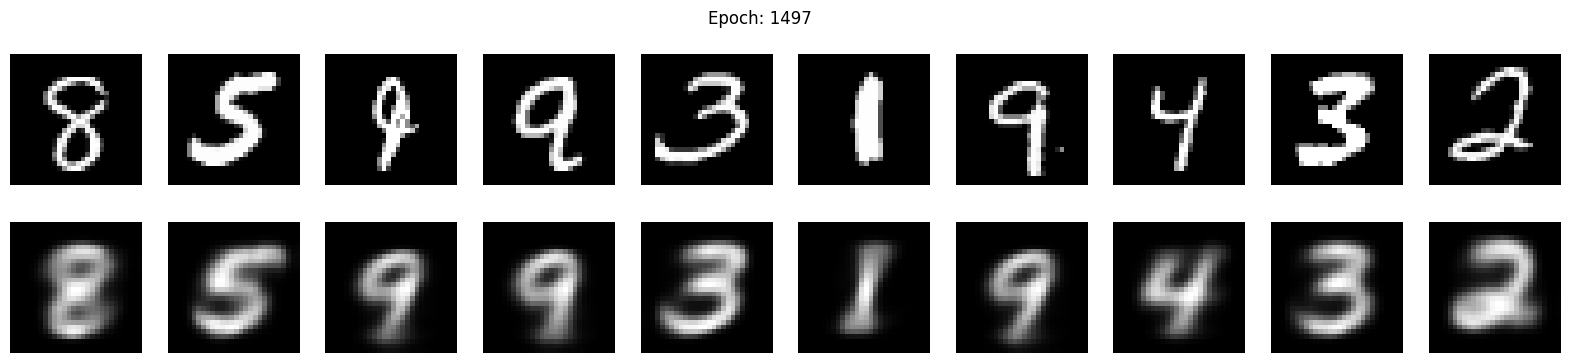

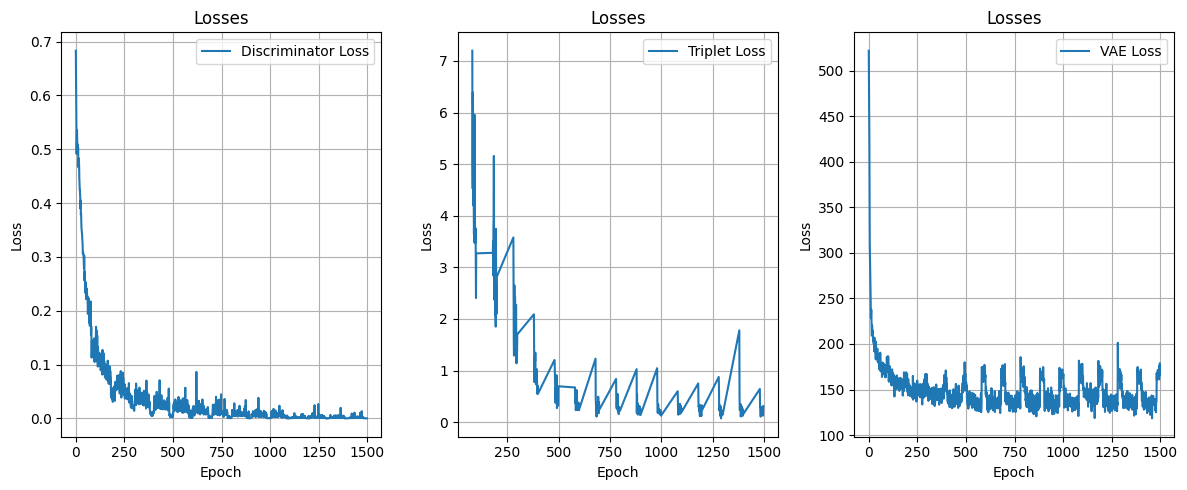

1/1 [==============================] - 0s 41ms/step
7


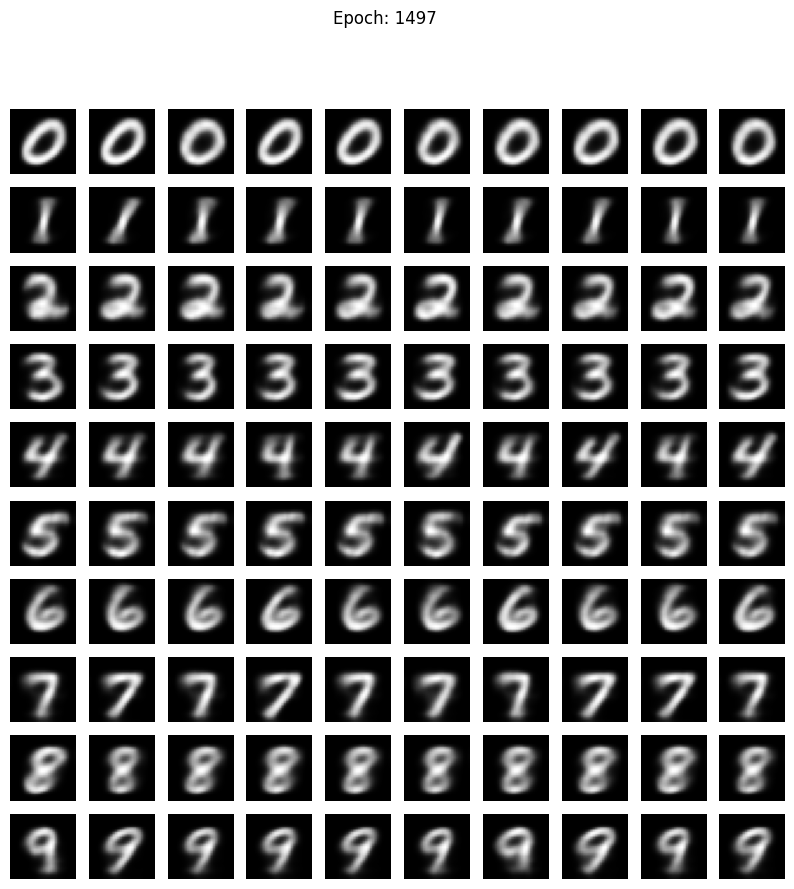

KeyboardInterrupt: Interrupted by user

In [89]:
dis_losses = []
gan_losses = [[],[]]
vae_losses = []
g_loss = 0

create_folder()

real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
    g_loss = 0
    if (epoch != 0) & (epoch % 250 == 0):
        if input('Продожить обучение? (Yes/No)') == 'No':
            break
    # Обучение дискриминатора
    discriminator.trainable = True
    for i in range(internal_train_cycles):
        idx      = np.random.randint(0, x_train.shape[0], batch_size)
        imgs     = x_train[idx]
        beton    = y_train_cat[idx]
        gen_imgs = decoder([encoder([imgs, beton])[2].numpy(), beton])

        d_loss_real = discriminator.train_on_batch([imgs, beton], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, beton], fake)
        d_loss      = 0.5 * np.add(d_loss_real, d_loss_fake)
    discriminator.trainable = False

    # Обучение VAE
    for i in range(internal_train_cycles):
        idx   = np.random.randint(0, x_train.shape[0], batch_size)
        imgs  = x_train[idx]
        beton = y_train_cat[idx]

        vae_loss_value = vae.train_on_batch([imgs, beton], imgs)

    # Обучение GAN
    if (epoch % 100 >= 80):
        for i in range(internal_train_cycles):
            idx   = np.random.randint(0, x_train.shape[0], batch_size)
            imgs, beton = apn_idxes(idx, 'train')

            g_loss = tlgan.train_on_batch([imgs[0],imgs[1],imgs[2], beton[0], beton[1], beton[2]], real)
        gan_losses[1].append(g_loss)
        gan_losses[0].append(epoch)

    # Сохранение значений loss
    dis_losses.append(d_loss[0])
    vae_losses.append(vae_loss_value)

    if epoch % 3 == 0:
        CO()
        print(f"{epoch} ",
              f"[D loss: {d_loss[0]} | acc.: {100*d_loss[1]}] ",
              f"[G loss: {g_loss}] ",
              f"[VAE loss: {vae_loss_value}]")

        # Визуализация изображений
        idx   = np.random.randint(0, x_test.shape[0], 10)
        imgs  = x_test[idx]
        beton = y_test_cat[idx]

        decoded_imgs = vae.predict([imgs, beton])
        plot_images(imgs, decoded_imgs, epoch, n=10)
        loss_graph(dis_losses, gan_losses, vae_losses)
        plot_images_train(x_test, y_test_cat, epoch)
        gc.collect()


In [90]:
image_dir = f'images/images_{foldernum}'

images_reconstructions = sorted([img for img in os.listdir(image_dir) if 'reconstructions' in img])

with II.get_writer('reconstructions_animation.gif', mode='I', duration=0.5, loop=0) as writer:
    for filename in images_reconstructions:
        image = II.v2.imread(os.path.join(image_dir, filename))
        writer.append_data(image)

print("Анимации созданы и сохранены как 'reconstructions_animation.gif'")

reconstructions_animation = Image(filename='reconstructions_animation.gif')

display(reconstructions_animation)


Анимации созданы и сохранены как 'reconstructions_animation.gif'


In [ ]:
# Сохранение весов моделей
if input('Вы хотите сохранить веса? (Yes/No)') == 'Yes':
    vae.save_weights('vae.weights.h5')
    discriminator.save_weights('discriminator.weights.h5')
    tlgan.save_weights('tlgan.weights.h5')
    decoder.save_weights('decoder.weights.h5')
    encoder.save_weights('encoder.weights.h5')


In [ ]:
# Загрузка весов моделей
if input('Вы хотите загрузить сохранённые веса? (Yes/No)') == 'Yes':
    vae.load_weights('vae.weights.h5')
    discriminator.load_weights('discriminator.weights.h5')
    tlgan.load_weights('tlgan.weights.h5')
    decoder.load_weights('decoder.weights.h5')
    encoder.load_weights('encoder.weights.h5')